In [1]:
import os as os
import sys as sys
import re as re
import pandas as pd
import numpy as np
import json as json
import pickle
import urllib as urllib
import zlib as zlib
import base64 as base64
from requests import Request, Session
import requests
from numpy import trapz
import itertools
import zlib as zlib
import base64 as base64
import pickle
import pathlib
from tqdm import tqdm
from datetime import datetime
import time
import copy
from Bio import SeqIO
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline
# from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report


pd.options.display.max_columns = 100
pd.options.display.min_rows = None
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 100

DATA_PATH = pathlib.Path('/data1/home/adpatter/gene-to-phenotype-predictions/adpatter/data/')
GENE_SYMBOL_EFFECT_SIZE = DATA_PATH.joinpath('capstone_body_weight_Statistical_effect_size_analysis_genotype_early_adult_scaled_13022023_gene_symbol_harmonized.pkl')
PROTEIN_SEQUENCE_PATH = DATA_PATH.joinpath('gene_symbol_protein_sequences.pkl')
EXON_SEQUENCE_PATH = DATA_PATH.joinpath('gene_symbol_dna_sequence_exon.pkl')
UNSPLICED_SEQUENCE_PATH = DATA_PATH.joinpath('gene_symbol_dna_sequence_unspliced.pkl')

In [ ]:
df = pd.read_pickle(GENE_SYMBOL_EFFECT_SIZE)

df = df.groupby(['gene_symbol_harmonized'])[['est_m_ea']].agg('mean')

df = df.reset_index()

kmeans = KMeans(n_clusters=3, init=np.array([[df['est_m_ea'].min()],[0],[df['est_m_ea'].max()]]), random_state=0).fit(df[['est_m_ea']].to_numpy())

df['class'] = kmeans.labels_

print(df['class'].value_coutns())

class_min = df['class'].value_counts().min()

df = df.groupby(['class']).sample(n=class_min)

df = df.groupby(['class']).sample(frac=1)

print(df['class'].value_coutns())

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_effect_size = df.copy()

df.shape

/data1/home/adpatter/.conda/envs/development/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


(1878, 3)

In [81]:
df = pd.read_pickle(PROTEIN_SEQUENCE_PATH)

df = df.rename({'seq': 'sequence'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_protein = df.copy()

df.shape

(1846, 4)

In [82]:
df = pd.read_pickle(EXON_SEQUENCE_PATH)

df = df.rename({'Sequence': 'sequence', 'Gene name': 'gene_symbol_harmonized'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_exon = df.copy()

df.shape

(1871, 4)

In [83]:
df = pd.read_pickle(UNSPLICED_SEQUENCE_PATH)

df = df.rename({'Sequence': 'sequence', 'Gene name': 'gene_symbol_harmonized'}, axis=1)

df = df.groupby(['gene_symbol_harmonized'])[['sequence']].agg(lambda x: ' '.join(x.tolist()))

df = df.reset_index()

df = _df_effect_size.merge(df, how='inner')

df = df[['gene_symbol_harmonized', 'est_m_ea', 'class', 'sequence']]

assert not df['gene_symbol_harmonized'].duplicated().any()

_df_unspliced = df.copy()

df.shape

(1871, 4)

In [62]:
def feature_density(df, ngram_range):

    tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=ngram_range)

    X = tfidf.fit_transform(df['sequence'].tolist())

    X = X.todense()

    df = pd.DataFrame(X, columns=tfidf.get_feature_names_out())

    df = df.T.copy()

    kmeans = KMeans(n_clusters=3, random_state=0).fit(df.to_numpy())

    df['Class'] = kmeans.labels_

    print(pd.Series(kmeans.labels_).value_counts())

    df = df.groupby(['Class']).apply(lambda x: ((x != 0).sum().sum()/(x.shape[0] * x.shape[1]), x.index.tolist())).to_frame(name='density_features').reset_index()

    df['Density'] = df.apply(lambda x: x['density_features'][0], axis=1)

    df['Features'] = df.apply(lambda x: x['density_features'][1], axis=1)

    df['Count'] = df['Features'].apply(lambda x: len(x))

    df = df.drop(['density_features'], axis=1)

    return df.copy()

In [63]:
_df_protein_features = feature_density(df=_df_protein, ngram_range=(4,4))

1    129489
2     22087
0       767
dtype: int64


In [64]:
_df_exon_features = feature_density(df=_df_exon, ngram_range=(10,10))

2    789706
1    229594
0        10
dtype: int64


In [65]:
_df_unspliced_features = feature_density(df=_df_unspliced.sample(frac=.1), ngram_range=(12,12))

0    5848839
2       2075
1         10
dtype: int64


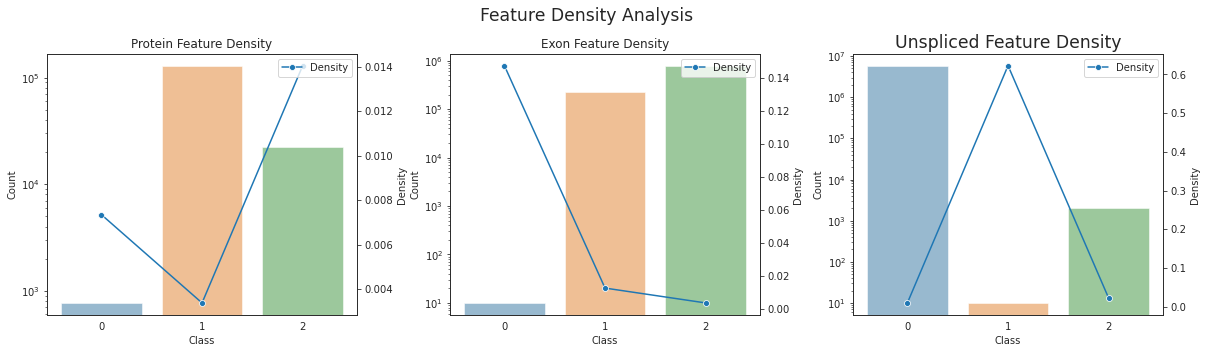

In [90]:
sns.set_style('white')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

fig.suptitle('Feature Density Analysis', fontsize='xx-large')
fig.set_size_inches((20,5))
fig.subplots_adjust(top=.85)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

sns.barplot(data=_df_protein_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax1)
ax1.set_yscale("log")
ax1.set_title('Protein Feature Density')
ax1_twin = ax1.twinx()
sns.lineplot(data=_df_protein_features, x='Class', y='Density', marker='o', label='Density', sort=False, ax=ax1_twin)
_= ax1_twin.legend(loc='upper right')

sns.barplot(data=_df_exon_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax2)
ax2.set_yscale("log")
ax2.set_title('Exon Feature Density')
ax2_twin = ax2.twinx()
sns.lineplot(data=_df_exon_features, x='Class', y='Density', marker='o', label='Density', sort = False, ax=ax2_twin)
_= ax2_twin.legend(loc='upper right')

sns.barplot(data=_df_unspliced_features.copy(), x='Class', y='Count', alpha=0.5, ax=ax3)
ax3.set_yscale("log")
ax3.set_title('Unspliced Feature Density')
ax3_twin = ax3.twinx()
sns.lineplot(data=_df_unspliced_features, x='Class', y='Density', marker='o', label='Density', sort = False, ax=ax3_twin)
_= ax3_twin.legend(loc='upper right')

In [84]:
df = _df_protein_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

protein_vocabulary = df['Features'].sum()

df = _df_exon_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

exon_vocabulary = df['Features'].sum()

df = _df_unspliced_features.copy()

df = df.loc[df['Density'] != df['Density'].min()]

unspliced_vocabulary = df['Features'].sum()

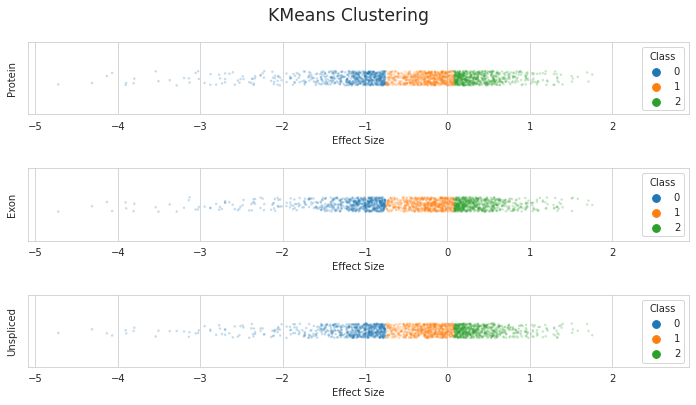

In [89]:
df = _df_protein.copy()

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Protein'] = ''

_df_protein_strip_plot = df.copy()

df = _df_exon.copy()

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Exon'] = ''

_df_exon_strip_plot = df.copy()

df = _df_exon.copy()

df = df.rename({'est_m_ea': 'Effect Size', 'class': 'Class'}, axis=1)

df['Unspliced'] = ''

_df_unspliced_strip_plot = df.copy()

sns.set_style('whitegrid')

fig, (ax1, ax2, ax3) = plt.subplots(3,1)

fig.suptitle('KMeans Clustering', fontsize='xx-large')
fig.set_size_inches((10,5.5))
fig.tight_layout()

_ = sns.stripplot(data=_df_protein_strip_plot, x='Effect Size', y='Protein', hue="Class", marker='.', alpha=.25, jitter=True,  ax=ax1)
_ = sns.stripplot(data=_df_exon_strip_plot, x='Effect Size', y='Exon', hue="Class", marker='.', alpha=.25, jitter=True,  ax=ax2)
_ = sns.stripplot(data=_df_unspliced_strip_plot, x='Effect Size', y='Unspliced', hue="Class", marker='.', alpha=.25, jitter=True,  ax=ax3)

plt.subplots_adjust(wspace=0.3, hspace=0.75)

In [91]:
df = _df_exon.copy()

X = df['sequence'].to_numpy()
y = df['class'].to_numpy()

In [92]:
print(df['class'].value_counts())

param_grid = {
    'tfidfVectorizer__ngram_range': [(4, 4)],
    'tfidfVectorizer__norm': ('l1', 'l2'),
    'SVC__kernel': ['linear', 'rbf'],
    'SVC__C': [0.001,0.01,0.1,1,10,100, 1000],
    'SVC__gamma': ['scale', 'auto']
}

pipe = Pipeline(steps=[
    ('tfidfVectorizer',  TfidfVectorizer(analyzer='char_wb', vocabulary=exon_vocabulary)),
    ('SVC', SVC())
    ])

gsSVC = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=3, verbose=3)

gsSVC.fit(X, y)

1    626
0    624
2    621
Name: class, dtype: int64
Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 3/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, tfidfVectorizer__ngram_range=(4, 4), tfidfVectorizer__norm=l1;, score=0.334 total time=   9.3s
[CV 1/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, tfidfVectorizer__ngram_range=(4, 4), tfidfVectorizer__norm=l1;, score=0.333 total time=  11.0s
[CV 2/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, tfidfVectorizer__ngram_range=(4, 4), tfidfVectorizer__norm=l1;, score=0.334 total time=  10.6s
[CV 4/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, tfidfVectorizer__ngram_range=(4, 4), tfidfVectorizer__norm=l1;, score=0.334 total time=   9.0s
[CV 1/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, tfidfVectorizer__ngram_range=(4, 4), tfidfVectorizer__norm=l2;, score=0.333 total time=   9.6s
[CV 5/5] END SVC__C=0.001, SVC__gamma=scale, SVC__kernel=linear, tfidfVectorizer__ngr

In [ ]:
df = pd.DataFrame(gsSVC.cv_results_)

df.loc[df['mean_test_score'] == df['mean_test_score'].max()]

In [ ]:
param_grid = {
    'tfidfVectorizer__ngram_range': [(4, 4)],
    'tfidfVectorizer__norm': ('l1', 'l2'),
    'logisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

pipe = Pipeline(steps=[
    ('tfidfVectorizer',  TfidfVectorizer(analyzer='char_wb')), 
    ('logisticRegression', LogisticRegression())
    ])

gsLogisticRegression = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=2, verbose=3)

gsLogisticRegression.fit(X, y)

In [ ]:
df = pd.DataFrame(gsLogisticRegression.cv_results_)

df.loc[df['mean_test_score'] == df['mean_test_score'].max()]

In [ ]:
param_grid = {
    'tfidfVectorizer__ngram_range': [(4, 4)],
    'dummyClassifier__strategy': ['uniform', 'most_frequent']
}

pipe = Pipeline(steps=[
    ('tfidfVectorizer',  TfidfVectorizer(analyzer='char_wb')), 
    ('dummyClassifier', DummyClassifier())
    ])

gsDummyClassifier = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=2, verbose=3)

gsDummyClassifier.fit(X, y)

In [ ]:
df = pd.DataFrame(gsDummyClassifier.cv_results_)

df